In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import ourProjectFunctions     # Python Function file with the functions we will use in the project. 

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Load a set of images
root_dir = "../training/"

image_dir = root_dir + "/images/"
files = os.listdir(image_dir)
n = min(10000, len(files)) # Load  100 images. 
print("Loading " + str(n) + " images")
imgs = [ourProjectFunctions.load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "/groundtruth/"

print("Loading " + str(n) + " images")
gt_imgs = [ourProjectFunctions.load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_004.png
Loading 100 images
satImage_004.png


In [18]:
from skimage import color
color.colorconv.lab_ref_white = np.array([0.96422, 1.0, 0.82521])

In [36]:
list_increased = list()

for img in imgs:
    lab = color.rgb2lab(img)
    img = np.append(img, lab)
    img = img.reshape([400, 400, 6])
    list_increased.append(img)

In [37]:
list_increased[0].shape

(400, 400, 6)

In [38]:
imgs = list_increased

In [39]:
# Extract patches from input images
patch_size = 16

img_patches = [ourProjectFunctions.img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [ourProjectFunctions.img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

X = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

print ("lenth and shape of Satellite  images after patching and  Linearisation: ")
print(X.shape)
print ("lenth and shape of Ground truth  images after patching and Linearisation: ")
print(gt_patches.shape)

lenth and shape of Satellite  images after patching and  Linearisation: 
(62500, 16, 16, 6)
lenth and shape of Ground truth  images after patching and Linearisation: 
(62500, 16, 16)


In [40]:
Y = np.asarray([ourProjectFunctions.value_to_class_for_tensor_flow(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [41]:
#img_size=10;
VALIDATION_SIZE = 2000
label_count = 2;
validation_images = X[:VALIDATION_SIZE]
validation_labels = Y[:VALIDATION_SIZE]

train_images = X[VALIDATION_SIZE:]
train_labels = Y[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(60500,16)
validation_images(2000,16)


In [42]:
import tensorflow as tf

In [44]:
labels_count = 2
data_nodes = tf.placeholder('float', shape=[None, patch_size, patch_size, 6])
label_nodes = tf.placeholder('float', shape=[None, labels_count])

In [45]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1, seed=SEED)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [46]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [47]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [63]:
SEED = 666 # For the submission
np.random.seed(SEED)


# first convolutional layer
W_conv1 = weight_variable([5, 5, 6, 32])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
#image = tf.reshape(X, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(40000,28,28,1)


h_conv1 = tf.nn.relu(conv2d(data_nodes, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
print (h_pool1.get_shape()) # => (40000, 14, 14, 32)

(?, 8, 8, 32)


In [64]:
#2nd convolution layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (128000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
print (h_pool2.get_shape()) # => (1280000, 7, 7, 64)

(?, 4, 4, 64)


In [65]:
# densely connected layer
W_fc1 = weight_variable([int(patch_size/4 * patch_size/4 * 64), 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, int(patch_size/4 * patch_size/4 * 64)])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
print (h_fc1.get_shape()) # => (40000, 1024)

(?, 1024)


In [66]:
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [67]:
# readout layer for deep net
labels_count =2
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [68]:
LEARNING_RATE = 1e-4


# cost function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, label_nodes))

# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
# train_step = tf.train.AdadeltaOptimizer(learning_rate=0.1).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(y),1), tf.argmax(label_nodes,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [69]:
predict = tf.argmax(tf.nn.softmax(y),1)

In [70]:
LEARNING_RATE = 1e-4
# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 1000
    
DROPOUT = 0.5
#BATCH_SIZES = 200

# set to 0 to train on all available data
VALIDATION_SIZES = 2000
BATCH_SIZE= 200

# image number to output
IMAGE_TO_DISPLAY = 10

In [71]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [72]:
def display_validation_stats():
    validation_accuracy = accuracy.eval(feed_dict={data_nodes: validation_images, 
                                                   label_nodes: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.3)
   
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

In [73]:
def generate_predictions():
    # Load submission images
    test_dir = '..\\test_set_images\\'
    submission_dir = '..\\submission\\'
    overlay_dir = '..\\submission_overlay\\'

    if not os.path.isdir(submission_dir):
        os.mkdir(submission_dir)

    if not os.path.isdir(overlay_dir):
        os.mkdir(overlay_dir)

    files = os.listdir(test_dir)

    for file in files:
        img = ourProjectFunctions.load_image(test_dir + file + '\\' + file + '.png')
        img_patches = ourProjectFunctions.img_crop(img, patch_size, patch_size)
        X = np.array(img_patches)

        prediction = sess.run(predict, feed_dict={ data_nodes: X, keep_prob: 1.0 })
        img_prediction = ourProjectFunctions.label_to_img(608, 608, patch_size, patch_size, prediction)

        img_overlay = ourProjectFunctions.make_img_overlay(img, img_prediction)

        save_path = file + ".png"
        Image.fromarray(ourProjectFunctions.img_float_to_uint8(img_prediction)).save(submission_dir + save_path)
        Image.fromarray(ourProjectFunctions.img_float_to_uint8(img_overlay)).save(overlay_dir + save_path)

In [74]:
init = tf.global_variables_initializer()

# Saver to be able to restore a model
saver = tf.train.Saver()
save_dir = '..\\tmp\\'

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

training_accuracy / validation_accuracy => 0.76 / 0.69 for step 0
training_accuracy / validation_accuracy => 0.68 / 0.71 for step 1
training_accuracy / validation_accuracy => 0.74 / 0.70 for step 2
training_accuracy / validation_accuracy => 0.75 / 0.70 for step 3
training_accuracy / validation_accuracy => 0.76 / 0.71 for step 4
training_accuracy / validation_accuracy => 0.90 / 0.71 for step 5
training_accuracy / validation_accuracy => 0.81 / 0.71 for step 6
training_accuracy / validation_accuracy => 0.70 / 0.71 for step 7
training_accuracy / validation_accuracy => 0.66 / 0.71 for step 8
training_accuracy / validation_accuracy => 0.88 / 0.71 for step 9
training_accuracy / validation_accuracy => 0.77 / 0.71 for step 10
training_accuracy / validation_accuracy => 0.77 / 0.71 for step 20
training_accuracy / validation_accuracy => 0.81 / 0.70 for step 30
training_accuracy / validation_accuracy => 0.67 / 0.70 for step 40
training_accuracy / validation_accuracy => 0.75 / 0.70 for step 50
train

ValueError: x and y must have same first dimension

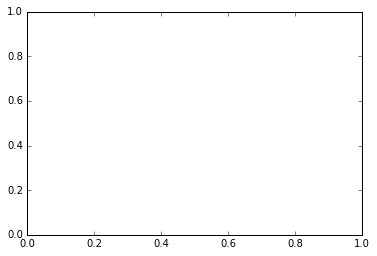

In [75]:
##### train_accuracies = []
validation_accuracies = []
x_range = []
image_size = 400;

display_step=1

with tf.Session() as sess:
    sess.run(init)
    
    for i in range(TRAINING_ITERATIONS):

        #get new batch
        batch_xs, batch_ys = next_batch(BATCH_SIZE)  


        # check progress on every 1st,2nd,...,10th,20th,...,100th... step
        if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:

            train_accuracy = accuracy.eval(feed_dict={data_nodes: batch_xs, 
                                                      label_nodes: batch_ys, 
                                                      keep_prob: 1.0})       
            if(VALIDATION_SIZE):
                validation_accuracy = accuracy.eval(feed_dict={ data_nodes: validation_images, 
                                                                label_nodes: validation_labels, 
                                                                keep_prob: 1.0})                                  
                print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d' % 
                      (train_accuracy, validation_accuracy, i))

                validation_accuracies.append(validation_accuracy)

            else:
                 print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
            train_accuracies.append(train_accuracy)
            x_range.append(i)

            # increase display_step
            if i%(display_step*10) == 0 and i:
                display_step *= 10
        
        # train on batch
        sess.run(train_step, feed_dict={data_nodes: batch_xs, label_nodes: batch_ys, keep_prob: DROPOUT})
    
    display_validation_stats()
    
    #generate_predictions()
    
    #saver.save(sess, '../tmpmodel')